In [3]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from math import ceil

sys.path.append('/Users/trevor/git/datascience-utils')
from db.mysql import MySqlContext
from db.redshift import RedshiftContextHc, RedshiftContextPh


pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

In [4]:
query = """
    SELECT
        s.product,
        l.subdivision_1_iso_code  AS state_code,
        l.metro_code::VARCHAR || l.subdivision_1_iso_code AS dma_state,
        l.city_name AS city,
        CASE WHEN r.revenue IS NOT null THEN 1 ELSE 0 END AS has_conversion,
        coalesce(r.revenue, 0.0) AS revenue
    FROM tracking.session_detail AS s
    INNER JOIN data_science.maxmind_ipv4_geo_blocks AS b
        ON ip_index(s.ip_address) = b.netowrk_index
        AND inet_aton(s.ip_address) BETWEEN b.start_int AND b.end_int
    INNER JOIN data_science.maxmind_geo_locations AS l
        ON b.maxmind_id = l.maxmind_id
    LEFT JOIN (
        SELECT
            session_id,
            sum(revenue) AS revenue
         FROM tron.session_revenue
         WHERE session_creation_date::DATE BETWEEN current_date - 29 AND current_date - 1
         GROUP BY 1
         HAVING sum(revenue) > 0.0
         ) AS r
         ON s.session_id = r.session_id
    WHERE nullif(s.ip_address, '') IS NOT null
        AND s.creation_date::DATE BETWEEN current_date - 29 AND current_date - 1
        AND l.country_iso_code = 'US'
        AND l.subdivision_1_iso_code != ''
        AND l.metro_code != ''
        AND lower(s.traffic_source) = 'google'
        AND s.domain = 'HC.COM'
    ;
"""

with RedshiftContextHc() as db_context:
    
    google_df = db_context.to_df(query)


google_df.head(5)

INFO:root:query: SELECT s.product, l.subdivision_1_iso_code  AS state_code, l... executed in 47.22 seconds


,product,state_code,dma_state,city,has_conversion,revenue
0,MEDICARE,KS,605KS,Topeka,1,25.7900
1,MEDICARE,CA,807CA,Dublin,1,3.1600
2,MEDICARE,CA,807CA,Burlingame,1,13.7600
3,MEDICARE,FL,534FL,Orlando,1,7.8500
4,HEALTH,GA,524GA,Alpharetta,1,4.6000


In [5]:
google_df['has_conversion'].sum()

88454

In [94]:
def calc_location_stats(df, segmentation, min_conversions=0):
    
    sessions_df = df.groupby(segmentation).size().reset_index(name='sessions').copy()

    metrics_df = df.groupby(segmentation)[['has_conversion', 'revenue']].sum()\
        .reset_index().rename(columns={'has_conversion': 'conversions'})

    df = sessions_df.merge(metrics_df, how='left', on=segmentation)
    df = df[df['conversions'] >= min_conversions]
    df.reset_index(drop=True, inplace=True)
    
    df['rps'] = df['revenue'] / df['sessions']
    
    return df


city_stats_df = calc_location_stats(google_df, ['product', 'state_code', 'dma_state', 'city'], 100)
dma_stats_df = calc_location_stats(google_df, ['product', 'state_code', 'dma_state'], 1)
state_stats_df = calc_location_stats(google_df, ['product', 'state_code'], 1)


print(city_stats_df.head(3))
print(dma_stats_df.head(3))
print(state_stats_df.head(3))

  product state_code dma_state         city  sessions  conversions   revenue  \
0  HEALTH         AL     630AL   Birmingham       922          132 2508.0700   
1  HEALTH         AZ     753AZ      Phoenix      1978          280 3939.5782   
2  HEALTH         CA     803CA  Los Angeles      2515          322 3413.9805   

     rps  
0 2.7202  
1 1.9917  
2 1.3574  
  product state_code dma_state  sessions  conversions  revenue    rps
0  HEALTH         AK     743AK       467           86 589.6103 1.2625
1  HEALTH         AK     745AK        75           13  55.1244 0.7350
2  HEALTH         AK     747AK        58            6  25.8086 0.4450
  product state_code  sessions  conversions    revenue    rps
0  HEALTH         AK       600          105   670.5433 1.1176
1  HEALTH         AL      4037          586 10384.4037 2.5723
2  HEALTH         AR      2257          325  5021.3458 2.2248


In [47]:
# check that all states have at least x conversions
state_stats_df[state_stats_df['conversions'] < 50].head(2)

,product,state_code,sessions,conversions,revenue


In [64]:


def welches_t_test(parent_sample_df, child_sample_df):

    results = dict()
    for label, df in [('parent', parent_sample_df), ('child', child_sample_df)]:
        
        conversions, revenue = df[['has_conversion', 'revenue']].sum()
        conversions = int(conversions)
        sessions = len(df)
        
        rps = revenue / sessions
        avg_value = revenue / conversions
        conv_rate = conversions / sessions
        
        results[label] = {
            'conversions': conversions,
            'revenue': revenue,
            'sessions': sessions,
            'rps': rps,
            'avg_value': avg_value,
            'conv_rate': conv_rate,
        }
    
    results['pval'] = ttest_ind(
        parent_sample_df['revenue'],
        child_sample_df['revenue'], 
        equal_var=False,
        nan_policy='omit'
    )[1]
    
    return results

In [65]:
city_sample = google_df[(google_df['dma_state'] == '528FL') & (google_df['city'] == 'Miami')]
dma_sample = google_df[(google_df['dma_state'] == '528FL') & (google_df['city'] != 'Miami')]


welches_t_test(dma_sample, city_sample)

{'parent': {'conversions': 538,
  'revenue': 10509.420759999999,
  'sessions': 4963,
  'rps': 2.1175540519846865,
  'avg_value': 19.534239330855016,
  'conv_rate': 0.10840217610316341},
 'child': {'conversions': 480,
  'revenue': 9471.056938000002,
  'sessions': 5124,
  'rps': 1.8483717677595632,
  'avg_value': 19.731368620833337,
  'conv_rate': 0.0936768149882904},
 'pval': 0.10360916247576556}

In [260]:
min_conversions = 200

header = ['product', 'state', 'dma_state', 'city', 'dma_rps', 'city_rps', 'pval']
rows = list()
for product in ['HEALTH', 'MEDICARE']:
    
    eligible_cities = city_stats_df[
        (city_stats_df['product'] == product) & 
        (city_stats_df['conversions'] >= min_conversions)
    ]

    for state, dma_state, city in eligible_cities[['state_code', 'dma_state', 'city']].values:

        df_slice = google_df[(google_df['product'] == product) & (google_df['dma_state'] == dma_state)]

        # generate sample sets
        dma_sample = df_slice[df_slice['city'] != city]
        city_sample = df_slice[df_slice['city'] == city]

        # if statement two purposes:
        # 1. handles edge cases where a dma_state has only one city, ex. washington dc
        # 2. makes sure dma has enough data after removing city data points
        if len(dma_sample) >= min_conversions:
            # run significance testing
            tstats = welches_t_test(dma_sample, city_sample)

            row = [product, state, dma_state, city, tstats['parent']['rps'], tstats['child']['rps'], tstats['pval']]
            rows.append(row)


city_exemptions = pd.DataFrame(rows, columns=header)

header = ['product', 'state', 'dma_state', 'state_rps', 'dma_rps', 'pval']
rows = list()
for product in ['HEALTH', 'MEDICARE']:
    
    eligible_dmas = dma_stats_df[
        (dma_stats_df['product'] == product) & 
        (dma_stats_df['conversions'] >= min_conversions)
    ]

    for state_code, dma_state in eligible_dmas[['state_code', 'dma_state']].values:

        df_slice = google_df[(google_df['product'] == product) & (google_df['state_code'] == state_code)]

        # generate sample sets
        state_sample = df_slice[df_slice['dma_state'] != dma_state]
        dma_sample = df_slice[df_slice['dma_state'] == dma_state]

        # if statement two purposes:
        # 1. handles edge cases where a dma_state has only one city, ex. washington dc
        # 2. makes sure dma has enough data after removing city data points
        if len(state_sample) >= min_conversions:
            
            # run significance testing
            tstats = welches_t_test(state_sample, dma_sample)

            row = [product, state_code, dma_state, tstats['parent']['rps'], tstats['child']['rps'], tstats['pval']]
            rows.append(row)


dma_exemptions = pd.DataFrame(rows, columns=header)

In [261]:
pval_threshold = .05

print(city_exemptions[city_exemptions['pval'] <= pval_threshold])

     product state dma_state         city  dma_rps  city_rps   pval
1     HEALTH    CA     803CA  Los Angeles   1.9416    1.3574 0.0001
22  MEDICARE    GA     524GA      Atlanta   2.8155    2.1046 0.0027
25  MEDICARE    NY     501NY     New York   1.5529    2.3498 0.0214
26  MEDICARE    OR     820OR     Portland   3.8103    2.7919 0.0156
29  MEDICARE    WA     819WA      Seattle   1.6001    2.3374 0.0138


In [262]:
pval_threshold = .05

print(dma_exemptions[dma_exemptions['pval'] <= pval_threshold])

     product state dma_state  state_rps  dma_rps   pval
2     HEALTH    CA     803CA     0.2084   1.8105 0.0000
3     HEALTH    CA     807CA     1.7834   0.1063 0.0000
4     HEALTH    CA     825CA     0.3758   1.7619 0.0000
5     HEALTH    CA     862CA     0.3604   1.9175 0.0000
8     HEALTH    FL     528FL     2.3623   1.9998 0.0010
10    HEALTH    FL     539FL     2.1546   2.6491 0.0002
14    HEALTH    IN     527IN     2.2531   2.8343 0.0306
36    HEALTH    PA     504PA     1.7827   1.4334 0.0039
44    HEALTH    VA     511VA     2.4777   1.8781 0.0047
45    HEALTH    VA     556VA     2.0454   2.8218 0.0425
49  MEDICARE    CA     803CA     0.5489   2.8254 0.0000
50  MEDICARE    CA     807CA     2.6658   0.2757 0.0000
51  MEDICARE    CA     825CA     0.8304   3.0226 0.0000
52  MEDICARE    CA     862CA     0.7985   2.8508 0.0000
57  MEDICARE    FL     539FL     2.0973   1.8100 0.0405
63  MEDICARE    MA     506MA     1.7391   2.1098 0.0310
78  MEDICARE    OR     820OR     2.1311   3.3168

array([<AxesSubplot:title={'center':'HEALTH'}>,
       <AxesSubplot:title={'center':'MEDICARE'}>], dtype=object)

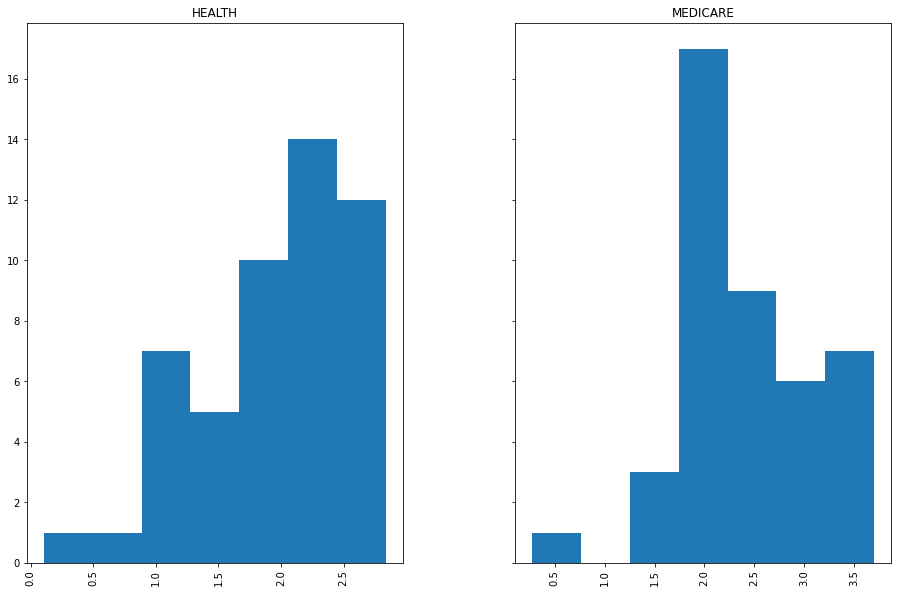

In [111]:
eligible_dmas = dma_stats_df[dma_stats_df['conversions'] >= min_conversions]
eligible_dmas[['product', 'rps']].hist(by='product', bins=7, figsize=(15,10), sharey=True)

In [118]:
product_df = calc_location_stats(google_df, ['product'])
product_df


,product,sessions,conversions,revenue,rps
0,HEALTH,367524,40859,574898.0176,1.5642
1,MEDICARE,244921,33384,481972.4046,1.9679


<AxesSubplot:title={'center':'Revenue Per Click By State'}, xlabel='rank,state_code'>

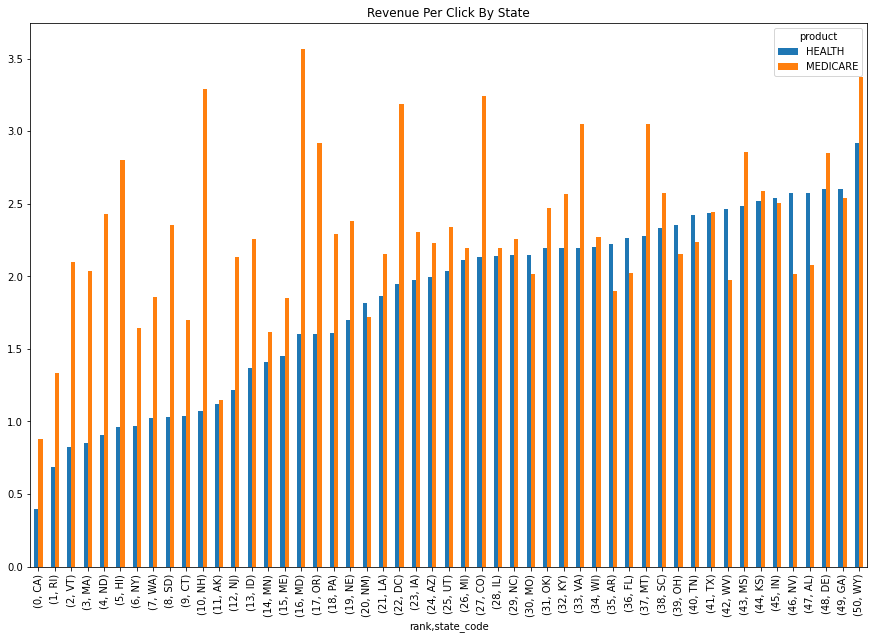

In [163]:
sort_product = 'HEALTH'

state_order_df = state_stats_df[state_stats_df['product'] == sort_product][['state_code', 'rps']]
state_order_df = state_order_df.set_index('rps').sort_index().reset_index()
state_order_df['rank'] = state_order_df.index
state_order_df = state_order_df[['state_code', 'rank']]

plot_df = state_stats_df.merge(state_order_df, how='inner', on='state_code')
plot_df.pivot_table(index=['rank', 'state_code'], columns='product', values='rps')\
    .plot.bar(figsize=(15,10), title='Revenue Per Click By State')



In [171]:
def generate_ranks_df(df, product):
    df = df[df['product'] == product][['state_code', 'rps']]
    df = df.set_index('rps').sort_index().reset_index()
    df['rank'] = df.index
    df = df[['state_code', 'rank']]
    return df


medicare_rank = generate_ranks_df(state_stats_df, 'MEDICARE')
health_rank = generate_ranks_df(state_stats_df, 'HEALTH')

medicare_rank.head(3), health_rank.head(3)


(  state_code  rank
 0         CA     0
 1         AK     1
 2         RI     2,
   state_code  rank
 0         CA     0
 1         RI     1
 2         VT     2)

array([[<AxesSubplot:title={'center':'HEALTH'}>,
        <AxesSubplot:title={'center':'MEDICARE'}>]], dtype=object)

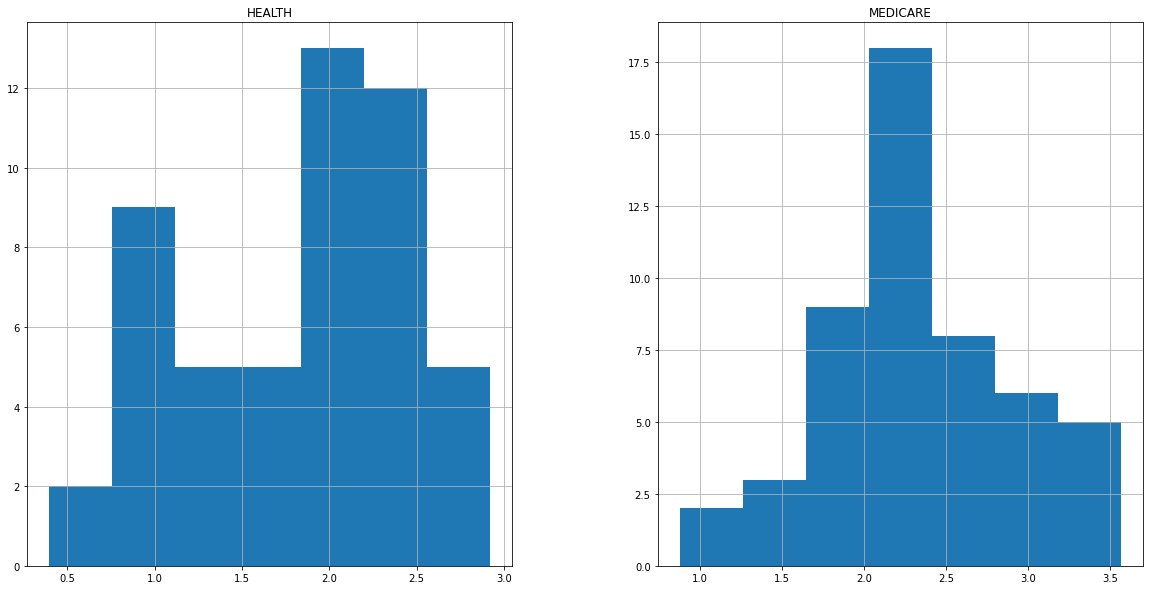

In [184]:
health_slice = state_stats_df[state_stats_df['product'] == 'HEALTH']\
    .merge(health_rank, how='inner', on='state_code')[['product', 'rank', 'rps']]

medicare_slice = state_stats_df[state_stats_df['product'] == 'MEDICARE']\
    .merge(medicare_rank, how='inner', on='state_code')[['product', 'rank', 'rps']]

dist_df = pd.concat([health_slice, medicare_slice])\
    .pivot_table(index='rank', columns='product', values='rps')

dist_df.hist(figsize=(20,10), bins=7)


<AxesSubplot:xlabel='rank'>

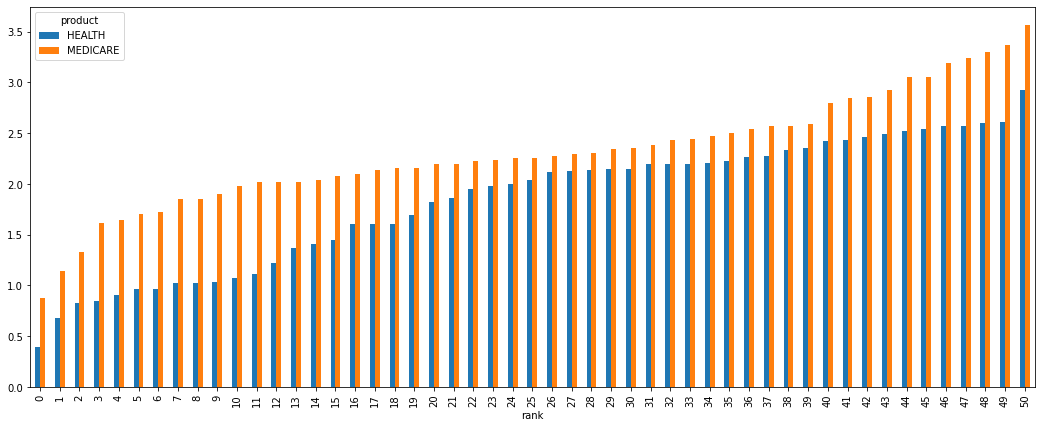

In [188]:
dist_df.plot.bar(figsize=(18,7))



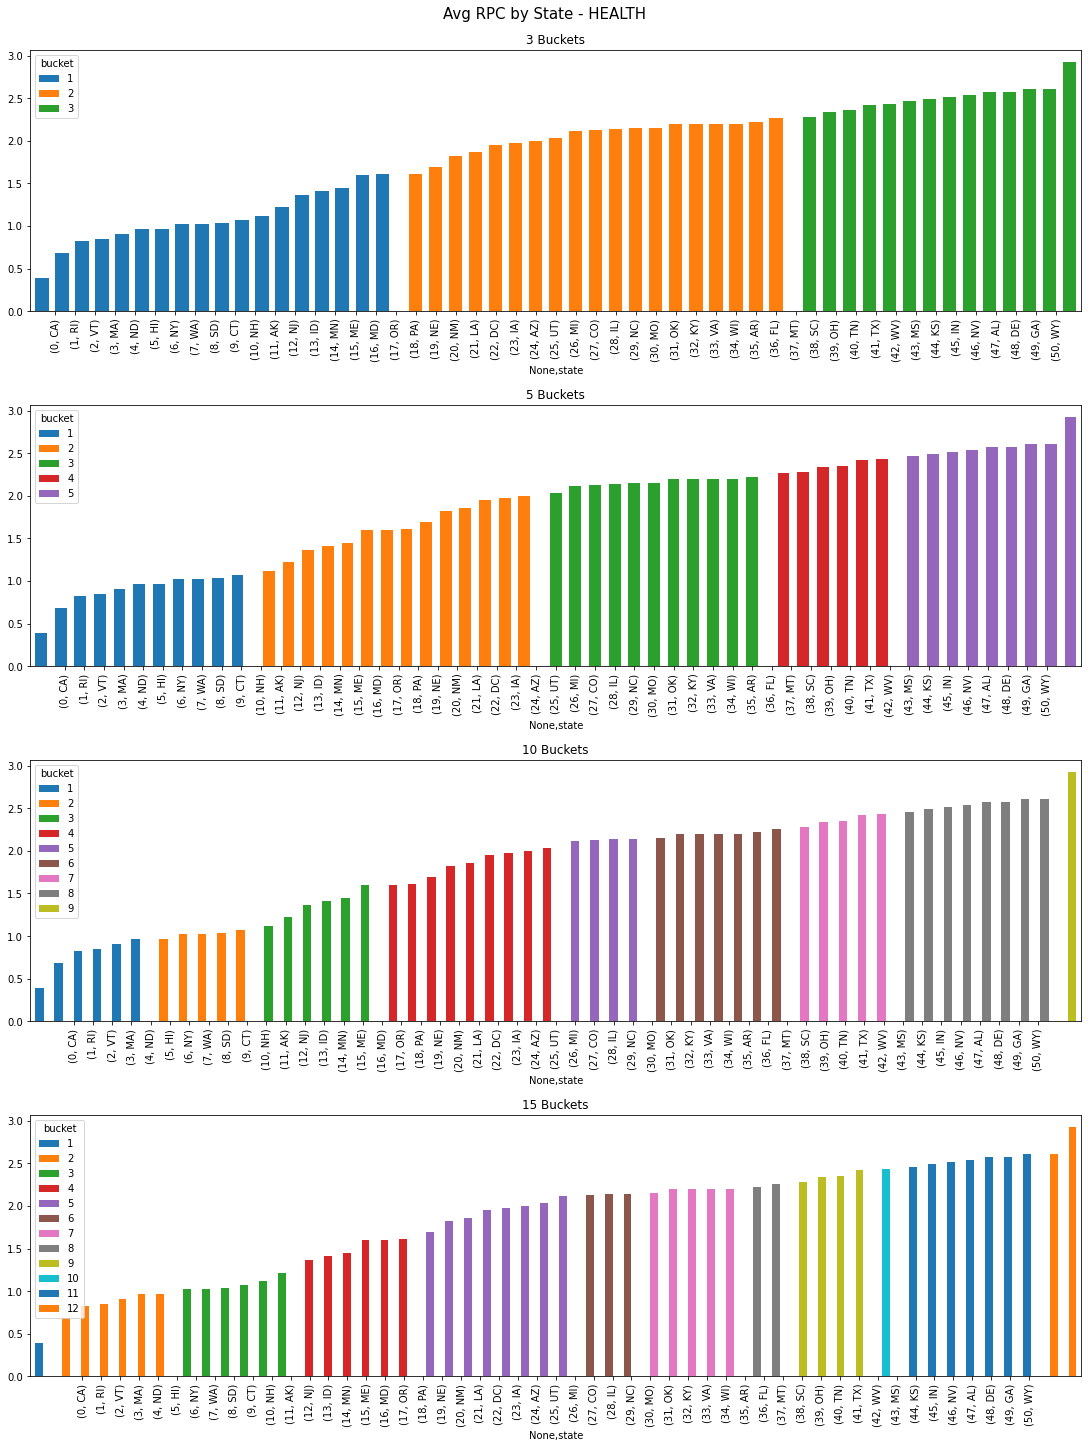

In [275]:
bucket_sets = [3, 5, 10, 15]

product = 'HEALTH'

fig, ax = plt.subplots(
    nrows=len(bucket_sets),
    ncols=1,
    figsize=(15, 5 * len(bucket_sets)),
    constrained_layout=True
)

for inc, buckets in enumerate(bucket_sets):
    
    rps_sorted = state_stats_df[state_stats_df['product'] == product].copy()\
        .sort_values(by='rps').set_index('rps').reset_index()

    conv_per_bucket = ceil(rps_sorted['conversions'].sum() / buckets)

    bucketed_states = list()
    cumulative_conversions = 0
    bucket_num = 1
    for state, conversions, rps in rps_sorted[['state_code', 'conversions', 'rps']].values:

        bucketed_states.append([state, rps, conversions, bucket_num])

        cumulative_conversions += conversions
        if cumulative_conversions > conv_per_bucket:
            cumulative_conversions = 0
            bucket_num += 1

    state_buckets = pd.DataFrame(bucketed_states, columns=['state', 'rps', 'conversions', 'bucket'])

    state_buckets.pivot_table(index=[state_buckets.index, 'state'], columns='bucket', values='rps')\
        .plot.bar(title=f'{buckets} Buckets', width=2 + (1 * inc), ax=ax[inc])

fig.suptitle(f'Avg RPC by State - {product}', fontsize=15)
fig.patch.set_facecolor('white')


In [270]:
def bucketize(df, buckets):

    dfs = list()
    for product in ['HEALTH', 'MEDICARE']:
        
        rps_sorted_df = df[df['product'] == product].copy().sort_values(by='rps').set_index('rps').reset_index()

        conv_per_bucket = ceil(rps_sorted_df['conversions'].sum() / buckets)
    
        bucketed_states = list()
        cumulative_conversions = 0
        bucket_num = 1

        for state, conversions, rps in rps_sorted[['state_code', 'conversions', 'rps']].values:
    
            bucketed_states.append([product ,state, rps, conversions, bucket_num])

            cumulative_conversions += conversions
            if cumulative_conversions > conv_per_bucket:
                cumulative_conversions = 0
                bucket_num += 1

        dfs.append(pd.DataFrame(bucketed_states, columns=['product', 'state', 'rps', 'conversions', 'bucket']))

    return pd.concat(dfs)


rpc_buckets_df = bucketize(state_stats_df, buckets=10)
rpc_buckets_df.pivot_table(index='state', columns='product', values=['bucket', 'rps']).head(10)


bucket             rps         
product HEALTH MEDICARE HEALTH MEDICARE
state                                  
AK           1        1 1.1473   1.1473
AL           3        4 2.0759   2.0759
AR           2        3 1.8994   1.8994
AZ           5        5 2.2299   2.2299
CA           1        1 0.8763   0.8763
CO           7        9 3.2424   3.2424
CT           2        2 1.7021   1.7021
DC           7        9 3.1866   3.1866
DE           7        8 2.8469   2.8469
FL           3        3 2.0229   2.0229

In [271]:
bucket_ranges_df = rpc_buckets_df.groupby(['product', 'bucket'], as_index=False)[['rps']].agg([min, max])

bucket_ranges_df.columns = list(map('_'.join, bucket_ranges_df.columns.values))

bucket_ranges_df['next_min'] = bucket_ranges_df['rps_min'].shift(-1)
bucket_ranges_df['previous_max'] = bucket_ranges_df['next_min'].shift(1)

bucket_ranges_df['next_min'].fillna(bucket_ranges_df['rps_max'] * 3.0, inplace=True)
bucket_ranges_df['previous_max'].fillna(0, inplace=True)

bucket_ranges_df[['rps_min', 'rps_max']] = bucket_ranges_df[['previous_max', 'next_min']]
bucket_ranges_df.drop(columns=['previous_max', 'next_min'], inplace=True)

bucket_ranges_df

rps_min  rps_max
product  bucket                  
HEALTH   1        0.0000   1.6426
         2        1.6426   2.0152
         3        2.0152   2.0969
         4        2.0969   2.2299
         5        2.2299   2.3401
         6        2.3401   2.5664
         7        2.5664   3.2939
         8        3.2939   0.8763
MEDICARE 1        0.8763   1.3306
         2        1.3306   1.8554
         3        1.8554   2.0382
         4        2.0382   2.1552
         5        2.1552   2.2562
         6        2.2562   2.4320
         7        2.4320   2.5391
         8        2.5391   3.0503
         9        3.0503  10.7033

In [263]:
city_exemptions[city_exemptions['pval'] <= 0.05]

,product,state,dma_state,city,dma_rps,city_rps,pval
1,HEALTH,CA,803CA,Los Angeles,1.9416,1.3574,0.0001
22,MEDICARE,GA,524GA,Atlanta,2.8155,2.1046,0.0027
25,MEDICARE,NY,501NY,New York,1.5529,2.3498,0.0214
26,MEDICARE,OR,820OR,Portland,3.8103,2.7919,0.0156
29,MEDICARE,WA,819WA,Seattle,1.6001,2.3374,0.0138


In [272]:
rpc_buckets_df[rpc_buckets_df['state'] == 'CA']

,product,state,rps,conversions,bucket
0,HEALTH,CA,0.8763,3307,1
0,MEDICARE,CA,0.8763,3307,1


In [268]:
dma_exemptions[dma_exemptions['pval'] <= 0.05]

,product,state,dma_state,state_rps,dma_rps,pval
2,HEALTH,CA,803CA,0.2084,1.8105,0.0000
3,HEALTH,CA,807CA,1.7834,0.1063,0.0000
4,HEALTH,CA,825CA,0.3758,1.7619,0.0000
5,HEALTH,CA,862CA,0.3604,1.9175,0.0000
8,HEALTH,FL,528FL,2.3623,1.9998,0.0010
10,HEALTH,FL,539FL,2.1546,2.6491,0.0002
14,HEALTH,IN,527IN,2.2531,2.8343,0.0306
36,HEALTH,PA,504PA,1.7827,1.4334,0.0039
44,HEALTH,VA,511VA,2.4777,1.8781,0.0047
45,HEALTH,VA,556VA,2.0454,2.8218,0.0425
